In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import warnings
import re
from collections import Counter

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)

In [2]:
path = 'movies'
df_movies = pd.read_csv(f'{path}.csv')

In [3]:
df_movies

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9994,The Imperfects,(2021– ),"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n \n Stars:\nMorgan Taylor Camp...,NaN,NaN,NaN
9995,Arcane,(2021– ),"\nAnimation, Action, Adventure",NaN,\nAdd a Plot\n,\n,NaN,NaN,NaN
9996,Heart of Invictus,(2022– ),"\nDocumentary, Sport",NaN,\nAdd a Plot\n,\n Director:\nOrlando von Einsiedel\n| \n ...,NaN,NaN,NaN
9997,The Imperfects,(2021– ),"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n Director:\nJovanka Vuckovic\n| \n Sta...,NaN,NaN,NaN


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    9999 non-null   object 
 1   YEAR      9355 non-null   object 
 2   GENRE     9919 non-null   object 
 3   RATING    8179 non-null   float64
 4   ONE-LINE  9999 non-null   object 
 5   STARS     9999 non-null   object 
 6   VOTES     8179 non-null   object 
 7   RunTime   7041 non-null   float64
 8   Gross     460 non-null    object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [5]:
print(f'Количество строк до удаления дупликатов: {len(df_movies)}')
df_movies.drop_duplicates(inplace=True)
print(f'Количество строк после удаления дупликатов: {len(df_movies)}')

Количество строк до удаления дупликатов: 9999
Количество строк после удаления дупликатов: 9568


In [6]:
print('Количество нулей в таблице \n\n')
df_movies.isna().sum()

Количество нулей в таблице 




MOVIES         0
YEAR         542
GENRE         78
RATING      1400
ONE-LINE       0
STARS          0
VOTES       1400
RunTime     2560
Gross       9108
dtype: int64

In [7]:
# удаление столбца Gross, так как он неинформативен с таким количеством пропусков
df = df_movies.drop('Gross', axis=1)
# приведение к числовому типу столбца VOTES
df['VOTES'] = df['VOTES'].str.replace(',', '').astype('float64')
# удаление строк, где отсутствует жанр
df = df[df['GENRE'].isna() == False]
df.head(3)

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,21062.0,121.0
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...",17870.0,25.0
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...",885805.0,44.0


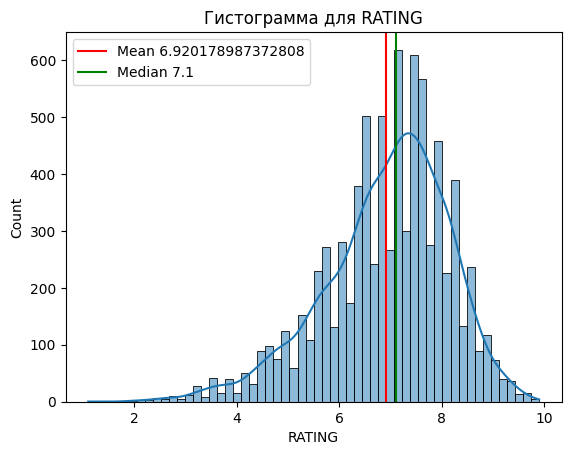

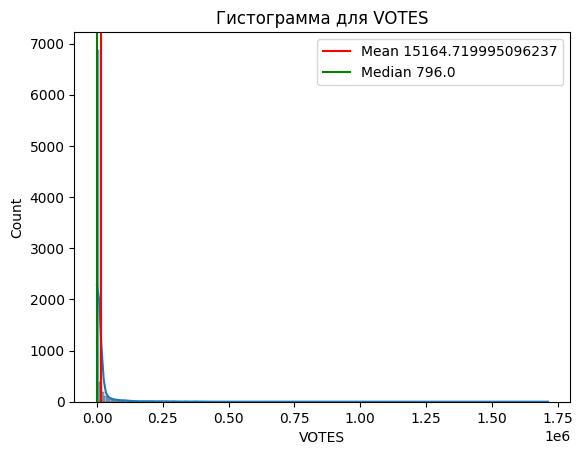

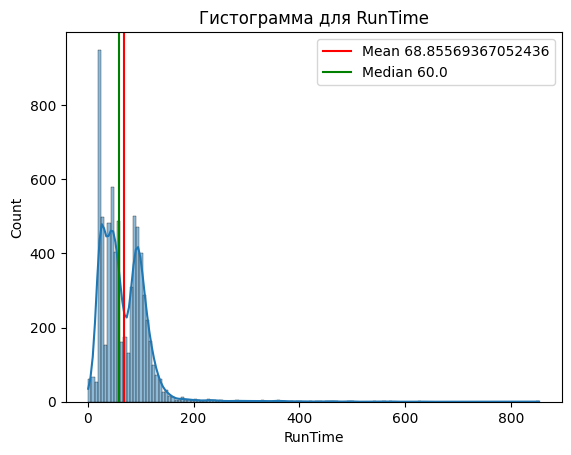

In [8]:
#  предварительный просмотр числовых столбцов для определния распределения значений
float_columns = df.select_dtypes(include=['float64']).columns

for col in float_columns:
    sns.histplot(df[col], kde=True)
    
    mean_value = df[col].mean()
    median_value = df[col].median()

    plt.axvline(mean_value, color='r', label=f'Mean {mean_value}')
    plt.axvline(median_value, color='g', label=f'Median {median_value}')

    plt.title(f'Гистограмма для {col}')
    plt.legend()

    plt.show()
    
    

In [9]:
#  НЕУДАЧНАЯ ПОПЫТКА ПРЕОБРАЗОВАНИЯ СТОЛБЦА С ГОДАМИ ВЫПУСКА

# dates = ['(I) (2020)','(2012– )', '(2018– )', '(I) (2021)', '(2010– )', '(2013– )']

# def extract_years(date):
#     years = re.findall(r'(\d{4})', date)
#     print(years)
#     if not years:
#         return np.nan, np.nan
#     start = int(years[0])
#     end = int(years[1]) if len(years) > 1 else np.nan
#     return start, end
# # extract_years('(I) (2024) TV_MOVIES')

# def extract_year(date):
#     start_year = re.findall(r'(\d{4})', date)
#     if not start_year:
#         return np.nan
#     return int(start_year[0])
# extract_year('(I) (2024-1111) TV_MOVIRS')

In [10]:
# Очистка и заполнение NaN
print(f'Количество строк до очистки: {len(df)}\n')
df['RATING'] = df['RATING'].fillna(df['RATING'].median())
df['VOTES'] = df['VOTES'].fillna(df['VOTES'].median())
df['RunTime'] = df['RunTime'].fillna(df['RunTime'].median())
# Преобразование столбца YEAR
df['YEAR'] = df['YEAR'].str.extract(r'(\d{4})').astype('Int64')
df['YEAR'] = df['YEAR'].fillna(df['YEAR'].median())


print(f'Количество строк после очистки: {len(df)}')
df.isna().sum()

Количество строк до очистки: 9490

Количество строк после очистки: 9490


MOVIES      0
YEAR        0
GENRE       0
RATING      0
ONE-LINE    0
STARS       0
VOTES       0
RunTime     0
dtype: int64

In [11]:
# Проверка на нормальность распределения
for col in float_columns:
    _, p = shapiro(df[col])
    print(p)
    print(f'Распределение столбца {col} является нормальным: {p > 0.05}')

2.5005267521488182e-46
Распределение столбца RATING является нормальным: False
1.8445049494889528e-108
Распределение столбца VOTES является нормальным: False
1.0280512879301593e-81
Распределение столбца RunTime является нормальным: False


In [12]:
# Обработка числовых столбцов от выбросов
for col in float_columns:
    print(f'Столбец: {col}')
    print(f'Статистика до:')
    print(df[col].describe())

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3-Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    print('Статистика после:')
    print(df[col].describe(), '\n')
print(f'Количество строк после фильтрации: {len(df)}')

Столбец: RATING
Статистика до:
count    9490.000000
mean        6.945437
std         1.132411
min         1.100000
25%         6.400000
50%         7.100000
75%         7.600000
max         9.900000
Name: RATING, dtype: float64
Статистика после:
count    9032.000000
mean        7.068025
std         0.928972
min         4.700000
25%         6.500000
50%         7.100000
75%         7.700000
max         9.300000
Name: RATING, dtype: float64 

Столбец: VOTES
Статистика до:
count    9.032000e+03
mean     1.346201e+04
std      6.479668e+04
min      5.000000e+00
25%      2.220000e+02
50%      7.960000e+02
75%      2.948250e+03
max      1.713028e+06
Name: VOTES, dtype: float64
Статистика после:
count    7611.000000
mean     1094.687295
std      1405.000682
min         5.000000
25%       160.000000
50%       772.000000
75%      1198.000000
max      7036.000000
Name: VOTES, dtype: float64 

Столбец: RunTime
Статистика до:
count    7611.000000
mean       61.343713
std        33.750263
min       

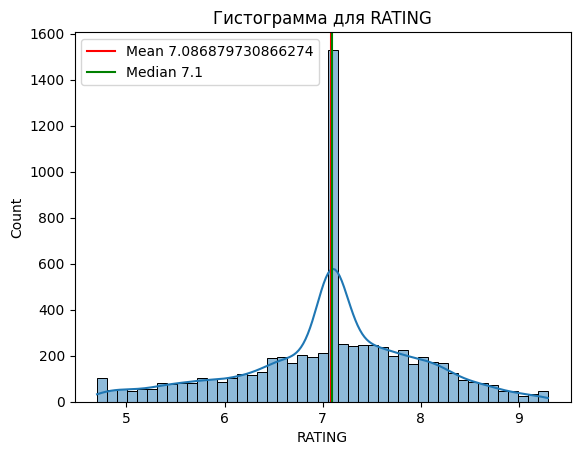

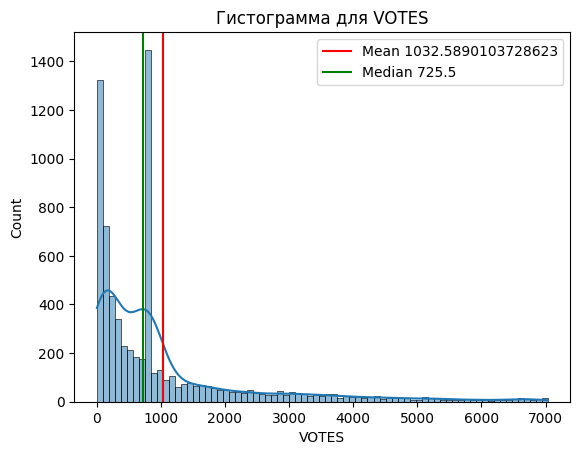

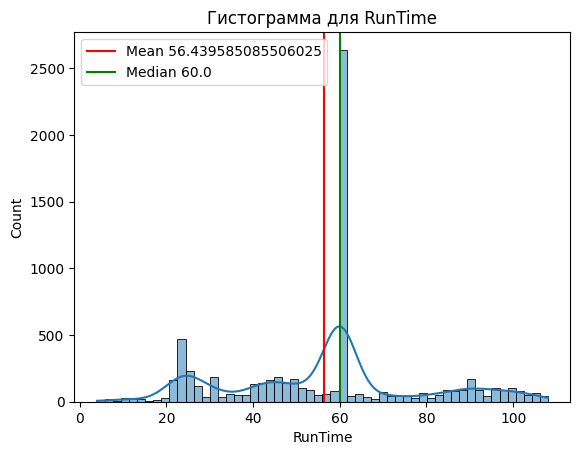

In [13]:
# Визуализация итогов преобразований
for col in float_columns:
    sns.histplot(df[col], kde=True)
    
    mean_value = df[col].mean()
    median_value = df[col].median()

    plt.axvline(mean_value, color='r', label=f'Mean {mean_value}')
    plt.axvline(median_value, color='g', label=f'Median {median_value}')

    plt.title(f'Гистограмма для {col}')
    plt.legend()
    
    plt.show()
    

In [14]:
# добавление столбца YEAR для дальнейшего кодирования
float_columns = float_columns.union(['YEAR'])
float_columns

Index(['RATING', 'RunTime', 'VOTES', 'YEAR'], dtype='object')

In [15]:
# кодирование числовых столбцов
scaler = {}
for col in float_columns:
    min_max_scaler = MinMaxScaler()
    scaler[col] = min_max_scaler
    df[col] = min_max_scaler.fit_transform(df[[col]])
df.head(3)

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime
4,Army of Thieves,0.978022,"\nAction, Crime, Horror",0.521739,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,0.112502,0.538462
24,He-Man and the Masters of the Universe,0.978022,"\nAnimation, Action, Adventure",0.521739,\nEternia's Prince Adam discovers the power of...,\n,0.112502,0.538462
64,Resort to Love,0.978022,"\nComedy, Romance",0.217391,"\nErica, who ends up as the entertainment at h...",\n Director:\nSteven K. Tsuchida\n| \n S...,0.225572,0.932692


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7134 entries, 4 to 9998
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOVIES    7134 non-null   object 
 1   YEAR      7134 non-null   float64
 2   GENRE     7134 non-null   object 
 3   RATING    7134 non-null   float64
 4   ONE-LINE  7134 non-null   object 
 5   STARS     7134 non-null   object 
 6   VOTES     7134 non-null   float64
 7   RunTime   7134 non-null   float64
dtypes: float64(4), object(4)
memory usage: 501.6+ KB


In [17]:
# Обработка и замена неинформативных/пустых записей
df['STARS'] = df['STARS'].replace({'\n': 'unknown'})
df['GENRE'] = df['GENRE'].str.strip()
df['ONE-LINE'] = df['ONE-LINE'].str.replace('Add a Plot', 'unknown').str.strip()
df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime
4,Army of Thieves,0.978022,"Action, Crime, Horror",0.521739,"A prequel, set before the events of Army of th...",\n Director:\nMatthias Schweighöfer\n| \n ...,0.112502,0.538462
24,He-Man and the Masters of the Universe,0.978022,"Animation, Action, Adventure",0.521739,Eternia's Prince Adam discovers the power of G...,unknown,0.112502,0.538462
64,Resort to Love,0.978022,"Comedy, Romance",0.217391,"Erica, who ends up as the entertainment at her...",\n Director:\nSteven K. Tsuchida\n| \n S...,0.225572,0.932692
74,Feels Like Ishq,0.978022,"Comedy, Drama, Romance",0.413043,Short films follow young adults as they naviga...,"\n \n Stars:\nJojo Singh, \nMihi...",0.119898,0.269231
81,Sky Rojo,0.978022,"Action, Adventure, Crime",0.391304,"Coral, Wendy, and Gina go on the run in search...","\n \n Stars:\nVerónica Sánchez, ...",0.986346,0.259615
...,...,...,...,...,...,...,...,...
9993,Totenfrau,0.989011,"Drama, Thriller",0.521739,unknown,\n Director:\nNicolai Rohde\n| \n Stars:...,0.112502,0.538462
9995,Arcane,0.978022,"Animation, Action, Adventure",0.521739,unknown,unknown,0.112502,0.538462
9996,Heart of Invictus,0.989011,"Documentary, Sport",0.521739,unknown,\n Director:\nOrlando von Einsiedel\n| \n ...,0.112502,0.538462
9997,The Imperfects,0.978022,"Adventure, Drama, Fantasy",0.521739,unknown,\n Director:\nJovanka Vuckovic\n| \n Sta...,0.112502,0.538462


In [18]:
# разбиение STARS на director и stars
df['STARS'] = df['STARS'].astype(str).str.replace('\n', '').str.split('|')
df['director'] = df['STARS'].apply(lambda x: x[0].replace('Director:', '').strip() if len(x) > 1 else 'unknown')
df['stars'] = df['STARS'].apply(lambda x: x[-1])
df['stars'] = df['stars'].replace(r'Star[s]?:', '', regex=True).str.strip()
df = df.drop('STARS', axis=1)
df

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,director,stars
4,Army of Thieves,0.978022,"Action, Crime, Horror",0.521739,"A prequel, set before the events of Army of th...",0.112502,0.538462,Matthias Schweighöfer,"Matthias Schweighöfer, Nathalie Emmanuel, Ruby..."
24,He-Man and the Masters of the Universe,0.978022,"Animation, Action, Adventure",0.521739,Eternia's Prince Adam discovers the power of G...,0.112502,0.538462,unknown,unknown
64,Resort to Love,0.978022,"Comedy, Romance",0.217391,"Erica, who ends up as the entertainment at her...",0.225572,0.932692,Steven K. Tsuchida,"Christina Milian, Tymberlee Hill, Kayne Lee Ha..."
74,Feels Like Ishq,0.978022,"Comedy, Drama, Romance",0.413043,Short films follow young adults as they naviga...,0.119898,0.269231,unknown,"Jojo Singh, Mihir Ahuja, Kajol Chugh, Sumali K..."
81,Sky Rojo,0.978022,"Action, Adventure, Crime",0.391304,"Coral, Wendy, and Gina go on the run in search...",0.986346,0.259615,unknown,"Verónica Sánchez, Miguel Ángel Silvestre, Asie..."
...,...,...,...,...,...,...,...,...,...
9993,Totenfrau,0.989011,"Drama, Thriller",0.521739,unknown,0.112502,0.538462,Nicolai Rohde,"Felix Klare, Romina Küper, Anna Maria Mühe, Ro..."
9995,Arcane,0.978022,"Animation, Action, Adventure",0.521739,unknown,0.112502,0.538462,unknown,unknown
9996,Heart of Invictus,0.989011,"Documentary, Sport",0.521739,unknown,0.112502,0.538462,Orlando von Einsiedel,Prince Harry
9997,The Imperfects,0.978022,"Adventure, Drama, Fantasy",0.521739,unknown,0.112502,0.538462,Jovanka Vuckovic,"Morgan Taylor Campbell, Iñaki Godoy, Rhianna J..."


In [19]:
# расчёт вероятностей для "категориальных" столбцов
for category in ['GENRE', 'stars']:
    df[category] = df[category].str.strip().str.split(',')
    category_count = Counter(df[category].explode().str.strip())
    category_prob = {}
    print(f'Количество встреч значений в {category}: {category_count.items()}')
    for categ, value in category_count.items():
        value /= sum(category_count.values())
        category_prob[categ] = value
    df[f'{category}_prob'] = df[category].apply(lambda x: sum(category_prob.get(category_.strip(), 0) for category_ in x))
    df = df.drop(category, axis = 1)

Количество встреч значений в GENRE: dict_items([('Action', 1524), ('Crime', 1036), ('Horror', 267), ('Animation', 1326), ('Adventure', 1219), ('Comedy', 2068), ('Romance', 599), ('Drama', 2920), ('History', 262), ('Documentary', 1040), ('Mystery', 603), ('Sport', 157), ('Reality-TV', 335), ('Biography', 192), ('Family', 360), ('Game-Show', 87), ('Fantasy', 381), ('Thriller', 566), ('Sci-Fi', 180), ('Short', 203), ('Western', 14), ('Music', 134), ('Musical', 43), ('War', 23), ('Talk-Show', 83), ('Film-Noir', 9), ('News', 17)])
Количество встреч значений в stars: dict_items([('Matthias Schweighöfer', 2), ('Nathalie Emmanuel', 1), ('Ruby O. Fee', 1), ('Stuart Martin', 1), ('unknown', 326), ('Christina Milian', 1), ('Tymberlee Hill', 1), ('Kayne Lee Harrison', 1), ('Ruth Nadler-Nir', 1), ('Jojo Singh', 1), ('Mihir Ahuja', 1), ('Kajol Chugh', 1), ('Sumali Khaniwale', 1), ('Verónica Sánchez', 18), ('Miguel Ángel Silvestre', 18), ('Asier Etxeandia', 18), ('Lali Espósito', 17), ('Steve Alterma

In [20]:
# предварительная оценка столбца director
df['director'].value_counts()

director
unknown                                    2862
Adam Heydt                                   28
Brian Smith                                  21
Oliver Driver                                21
Giancarlo Volpe                              18
                                           ... 
David Oyelowo                                 1
Kyohei Ishiguro                               1
Matt Thompson                                 1
Directors:Derek Drymon, Jennifer Kluska       1
Garth Jennings                                1
Name: count, Length: 2438, dtype: int64

In [21]:
# удаление столбцов в связи с малой информативностью
df = df.drop(['director', 'ONE-LINE'], axis = 1)

In [22]:
df.head()

,MOVIES,YEAR,RATING,VOTES,RunTime,GENRE_prob,stars_prob
4,Army of Thieves,0.978022,0.521739,0.112502,0.538462,0.180662,0.000202
24,He-Man and the Masters of the Universe,0.978022,0.521739,0.112502,0.538462,0.260033,0.013152
64,Resort to Love,0.978022,0.217391,0.225572,0.932692,0.170437,0.000161
74,Feels Like Ishq,0.978022,0.413043,0.119898,0.269231,0.357042,0.000161
81,Sky Rojo,0.978022,0.391304,0.986346,0.259615,0.241501,0.002864


In [23]:
#  кодирование названий фильмов
movies_prob = df.MOVIES.value_counts(normalize=True)
df['movies_prob'] = df['MOVIES'].map(movies_prob)
df = df.drop('MOVIES', axis = 1)
movies_prob

MOVIES
 Bleach: Burîchi                         0.009111
 La Reina de Indias y el Conquistador    0.008410
 Avatar: The Last Airbender              0.007289
 The Drew Barrymore Show                 0.006308
 Dexter                                  0.005887
                                           ...   
De nærmeste                              0.000140
Arifureta Shokugyou de Sekai Saikyou     0.000140
 Totenfrau                               0.000140
 Arcane                                  0.000140
 Heart of Invictus                       0.000140
Name: proportion, Length: 4518, dtype: float64

In [24]:
df.head(3)

,YEAR,RATING,VOTES,RunTime,GENRE_prob,stars_prob,movies_prob
4,0.978022,0.521739,0.112502,0.538462,0.180662,0.000202,0.00014
24,0.978022,0.521739,0.112502,0.538462,0.260033,0.013152,0.00014
64,0.978022,0.217391,0.225572,0.932692,0.170437,0.000161,0.00014


<Axes: >

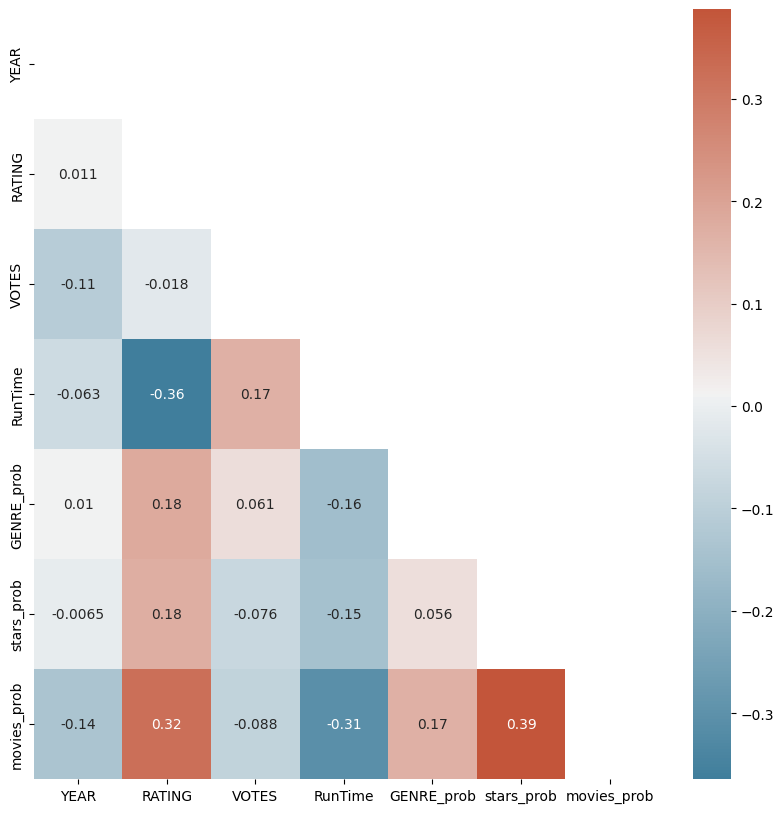

In [25]:
# оценка корелляций
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)

In [26]:
# ИТОГОВЫЙ ФРЕЙМ
df

,YEAR,RATING,VOTES,RunTime,GENRE_prob,stars_prob,movies_prob
4,0.978022,0.521739,0.112502,0.538462,0.180662,0.000202,0.000140
24,0.978022,0.521739,0.112502,0.538462,0.260033,0.013152,0.000140
64,0.978022,0.217391,0.225572,0.932692,0.170437,0.000161,0.000140
74,0.978022,0.413043,0.119898,0.269231,0.357042,0.000161,0.000140
81,0.978022,0.391304,0.986346,0.259615,0.241501,0.002864,0.000140
...,...,...,...,...,...,...,...
9993,0.989011,0.521739,0.112502,0.538462,0.222776,0.000323,0.000140
9995,0.978022,0.521739,0.112502,0.538462,0.260033,0.013152,0.000140
9996,0.989011,0.521739,0.112502,0.538462,0.076495,0.000081,0.000140
9997,0.978022,0.521739,0.112502,0.538462,0.288855,0.000524,0.000421


In [27]:
# разделение на train/test группы
# X = df.drop('GENRE_prob', axis=1)
# y = df['GENRE_prob']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# df_train = X_train.join(y_train)
# print(len(df))
# print(len(df_train))
# df_train